In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib import cm

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from fluids import ATMOSPHERE_1976

import xarray as xr 
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata
from matplotlib import cm
#matplotlib notebook
%matplotlib widget

In [2]:
def aggregate_data(base_dir, month, day, write=False):

    """With a folder containing multiple station's worth of Radiosonde data, create a concatenated CSV of all radiosonde data from the 
    given day of the given month.\\
    
    base_dir: Directory containing all station data folders.\\
    month: integer from 1-12\\
    day: integer from 1-x, based on which month you select"""

    print('AGGREGATION... ')

    csv_list = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder+'/2023/') #Can modify this for the year

        folder_path = os.path.join(folder_path, str(month)) #create a path to the folder for the month you want data from

        if os.path.isdir(folder_path):
                #Finds every csv in the selected month folder
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

                if csv_files:
                    # Read the X-th (x is the day you choose) CSV file in the selected folder
                    first_csv_path = os.path.join(folder_path, csv_files[day])
                    
                    # Append the path to the list
                    csv_list.append(first_csv_path)

    df_list = []

    # Loop through the csv_list and read each CSV file
    for csv_path in csv_list:
        df = pd.read_csv(csv_path)

        #create a new column for the date and time of the reading
        datetime = csv_path.split('/')[-1].split('.')[0].split('-')[1:]
        timestep = '-'.join(datetime)
        df['TIMESTEP'] = timestep
        df_list.append(df)

    # Concatenate all the DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True).drop('Unnamed: 0', axis = 1)

    # Save the concatenated DataFrame to a new CSV file if write == True
    if write == True: 
        output_csv_path = '/path/to/save/concatenated.csv'
        concatenated_df.to_csv(output_csv_path, index=False)

    print('AGGREGATION : DONE.')
    return concatenated_df

In [3]:
def create_synthetic_stations(df, lat_min, lat_max, lon_min, lon_max, step, alt_step=250):

    """Use: Create a (optionally) high resolution 3-D grid of radiosonde data within a specific longitude-latitude and altitude range, 
    provided you have prior data to synthesize from.\\
    
    df: Dataframe produced by aggregate_data function, based on existing radiosonde data.\\
    lat_min: minimum latitude of region determined by df.\\
    lat_max: maximum latitude of region determined by df.\\
    lon_min: minimum longitude of region determined by df.\\
    lon_max: maximum longitude of region determined by df.\\
    step: resolution in latitude-longitude for which to generate data. (Ex. step = 1 means data will be generated each 1 lat-lon degrees).\\
    alt_step: Vertical resolution in meters for which to generate data. (Ex. alt_step = 250 means data will be generated every 250 meters.)
    """

    print('SYNTHESIZING...')

    #Creates a range of lats/lons used for coordiantes when making data.
    latitudes = np.arange(lat_min, lat_max + step, step) 
    longitudes = np.arange(lon_min, lon_max + step, step)
    
    # Define altitude range based on the min and max altitudes in the original data
    alt_min, alt_max = df['height'].min(), df['height'].max()
    altitudes = np.arange(alt_min, alt_max + alt_step, alt_step)
    
    synthetic_data = []

    station_number = 0 

    for lat in latitudes:
        for lon in longitudes:
            station_number += 1
            # Interpolate data for each altitude level
            for altitude in altitudes:
                #Collect data into layers based on alt_step distance. 
                df_alt = df[(df['height'] >= altitude) & (df['height'] < altitude + alt_step)]
                if df_alt.empty:
                    continue
                
                #Collect all features corresponding to selected lat/lon ranges. 
                points = df_alt[['latitude', 'longitude']].values
                columns = ['pressure','height','temperature','direction','speed','u_wind','v_wind']
                
                interpolated_values = {}
                for column in columns:
                    values = df_alt[column].values
                    #Utilize Nearest neighbor interpolation to fill empty spaces on 3d grid. 
                    interpolated_values[column] = griddata(points, values, (lat, lon), method='nearest')

                synthetic_data.append({
                    **interpolated_values,
                    'station_number': station_number,
                    'latitude': lat,
                    'longitude': lon,
                    'height': altitude
                })
    
    synthetic_df = pd.DataFrame(synthetic_data)
    print('SYNTHESIS : DONE.')
    return synthetic_df

In [4]:
def smooth(x, lats, lons, sigma):

    """Use: Helper function that will smooth a variable on a single altitude layer.\\
    x: list-like of variables needing to be smoothed.\\
    lats: latitude dimension (Number of unique latitude values in data).\\
    lons: longitude dimension (Number of unique longitude values in data).\\
    sigma: Standard deviation of guassian kernel (Higher value = more homogenous result overall)."""

    x = np.array(x).reshape((lats,lons)) #Reshape data into a matrix matching the geographic grid. 
    x1 = gaussian_filter(x, sigma=sigma) #apply smoothing across the matrix. 
    x1 = np.concatenate(x1, axis=0) #concatenate back to a numpy array for compatibility with later functions. 

    return x1

def get_dims(df):
    lats = df['latitude'].nunique()
    lons = df['longitude'].nunique()
    alts = df['height'].nunique()

    return (lats, lons, alts)


def glob_smooth(df, lats, lons, alts):

    """Use: With a synthetic dataframe produced by the create_synthetic_stations function, apply a gaussian smoothing 
    to each altitude layer and re-stack in order to produce a complete dtaframe of synthetic winds.\
    
    df: Synthetic dataframe from create_synthetic_stations.\\
    lats: Dimensions of latitude data. (Ex. Data has a latitude range of 70-110; lats = 40)\\
    lons: Dimensions of longitude data. (Ex. Same logic as latitudes)\\
    alts: Dimensions of altitude data. (Ex. Number of altitude levels in data) """
    
    print("SMOOTHING...")

    speed = []
    u = []
    v = []
    for i in range(0,alts): #For eahc altitude layer
        for j in range(0,lats*lons): #For each station in the latitude-longitude grid 
            idx = alts * j + i #Each station index
            speed.append(df['speed'][idx]) #Add data to a list for processing
            u.append(df['u_wind'][idx])
            v.append(df['v_wind'][idx])


        #Apply helper function for smoothing all desired variables. 
        speed1 = smooth(speed, lats, lons, 2)
        u1 = smooth(u, lats, lons, 3)
        v1 = smooth(v, lats, lons, 3)

        for j in range(0, lats*lons): #Re-create a dataframe based on structure of origina ldata with synthetic values. 
            idx = alts * j + i
            df.at[idx, 'speed'] = speed1[j]
            df.at[idx, 'u_wind'] = u1[j]
            df.at[idx, 'v_wind'] = v1[j]

        speed.clear() #clear lists for use in next altitude layer. 
        u.clear()
        v.clear()

    
    print('SMOOTHING : DONE.')
    return df

In [5]:
def plot_layer(df, type, height:int):
    if height not in df['height'].unique():
        raise ValueError("Invalid height value")

    if type == 'xy':
        x = df[df['height'] == height ]['longitude'].values
        y = df[df['height'] == height]['latitude'].values
        u = df[df['height'] == height]['u_wind'].values
        v = df[df['height'] == height]['v_wind'].values
        w = np.zeros_like(u)
        speed = df[df['height'] == height]['speed'].values

        '''
        u = u.astype(float)
        v = v.astype(float)
        print( u)
        speed = np.sqrt(u**2 + v**2)
        '''
        speed = speed/1.94
        speed = speed.astype('int')

        print(u)

        norm = plt.Normalize(min(speed), max(speed))
        colors = cm.hsv(norm(speed))

        fig = plt.figure(figsize=(10,12))
        ax = fig.add_subplot(111, projection = '3d')
        mappable = cm.ScalarMappable(cmap=cm.hsv, norm=norm)
        mappable.set_array(speed)
        cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
        cbar.set_label('Wind Speed')

        for i in range(len(x)):
            ax.quiver(x[i], y[i], height, u[i], v[i], w[i], colors=colors[i], length=1, arrow_length_ratio=.5, normalize=True)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Height Level')

        #ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()

In [6]:
base_dir = r"/mnt/d/RadioWinds/SOUNDINGS_DATA" 
df = aggregate_data(base_dir, 1, 0)

print(df)

df = df[(df['height'] >= 15000) & (df['height'] <= 28000)] #Select desired altitude ranges
df = df.drop('station', axis=1).dropna() #Getting rid of unneeded columns
#Analytically selected lat/lon ranges
df = df[(df['longitude'] >= 90) & (df['longitude'] <= 131.3) & (df['latitude'] <= 18) &(df['latitude'] >= -12.4)]
#df = df[(df['longitude'] >= -135) & (df['longitude'] <= -100) & (df['latitude'] <= 45) &(df['latitude'] >= 15)]

lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
step = 1
synth_df = create_synthetic_stations(df, lat_min, lat_max, lon_min, lon_max, step)

AGGREGATION... 
AGGREGATION : DONE.
       pressure   height  temperature  dewpoint  direction  speed      u_wind  \
0         835.0   1619.0         11.4       1.4      260.0    8.0    7.878462   
1         830.0   1669.0         10.8      -0.2      256.0   10.0    9.702957   
2         823.0   1739.0         10.0       0.0      250.0   13.0   12.216004   
3         817.0   1799.0          9.6      -0.2      245.0   15.0   13.594617   
4         788.0   2093.0          7.6      -1.4      250.0   16.0   15.035082   
...         ...      ...          ...       ...        ...    ...         ...   
43710       8.0  31304.0        -67.1     -95.1      275.0   85.0   84.676549   
43711       7.9  31394.0        -67.0     -95.0      275.0   86.0   85.672744   
43712       7.2  31940.0        -66.3     -94.3      275.0  101.0  100.615665   
43713       7.1  32024.0        -66.3     -94.3      275.0  103.0  102.608054   
43714       7.0  32110.0        -66.3     -94.3      275.0  103.0  102.60

In [394]:
#Smooth Data
lats, lons, alts = get_dims(synth_df)
synth_df = glob_smooth(synth_df, lats, lons, alts)


SMOOTHING...
SMOOTHING : DONE.


In [7]:
synth_df['timestep'] = df["TIMESTEP"].unique()[0]
#synth_df.index = synth_df['timestep']
synth_df = synth_df.drop(columns=['temperature','direction','station_number'])
pres = []
for i in range(0, len(synth_df)):
    atm = ATMOSPHERE_1976(Z=synth_df['height'][i])
    pres.append(atm.P/100)
synth_df['pressure'] = pres
synth_df['u_wind'] = synth_df['u_wind']/1.94384
synth_df['v_wind'] = synth_df['v_wind']/1.94384

In [8]:
print(synth_df['timestep'])

0        2023-1-1-0
1        2023-1-1-0
2        2023-1-1-0
3        2023-1-1-0
4        2023-1-1-0
            ...    
58235    2023-1-1-0
58236    2023-1-1-0
58237    2023-1-1-0
58238    2023-1-1-0
58239    2023-1-1-0
Name: timestep, Length: 58240, dtype: object


In [9]:
synth_df['timestep'] = synth_df['timestep'].apply(lambda x: '-'.join([f'{int(part):02d}' for part in x.split('-')]))
synth_df['timestep'] = pd.to_datetime(synth_df['timestep'], format='%Y-%m-%d-%H')

In [10]:
synth_df['height'] = synth_df['height']*9.81
#synth_df['latitude'] = synth_df['latitude'].values[::-1]

In [11]:
synth_df = synth_df.round(2)

In [13]:
synth_df = synth_df.reindex(index=synth_df.index[::-1])
synth_df = synth_df.reset_index(drop=True)

In [411]:
#synth_df['latitude'] = synth_df['latitude'].values[::-1]
#synth_df['longitude'] = synth_df['longitude'].values[::-1]

In [14]:
print(synth_df)

       pressure     height speed     u_wind     v_wind  latitude  longitude  \
0         16.77  272276.55  13.0   1.730928  -6.459912     16.84     131.71   
1         17.42  269824.05   9.0   3.598194   -2.91376     16.84     131.71   
2         18.09  267371.55  12.0   4.365216   4.365216     16.84     131.71   
3         18.79  264919.05  10.0   4.214092  -2.950739     16.84     131.71   
4         19.51  262466.55  13.0  -6.061199  -2.826384     16.84     131.71   
...         ...        ...   ...        ...        ...       ...        ...   
58235    103.45  157009.05  57.0 -24.592673 -15.970669    -10.16      92.71   
58236    107.59  154556.55  74.0 -35.042678 -14.874734    -10.16      92.71   
58237    111.89  152104.05  93.0 -47.116594  -8.307927    -10.16      92.71   
58238    116.37  149651.55  85.0 -43.561481   3.811136    -10.16      92.71   
58239    121.02  147199.05  66.0 -33.870703   -2.36847    -10.16      92.71   

        timestep  
0     2023-01-01  
1     2023-01

In [22]:
print( synth_df['height'][51])
print( synth_df['pressure'][51])

152104.05
111.89


[-11.13807468444469 -11.13807468444469 -11.13807468444469 ...
 -33.87070299877994 -33.87070299877994 -33.87070299877994]


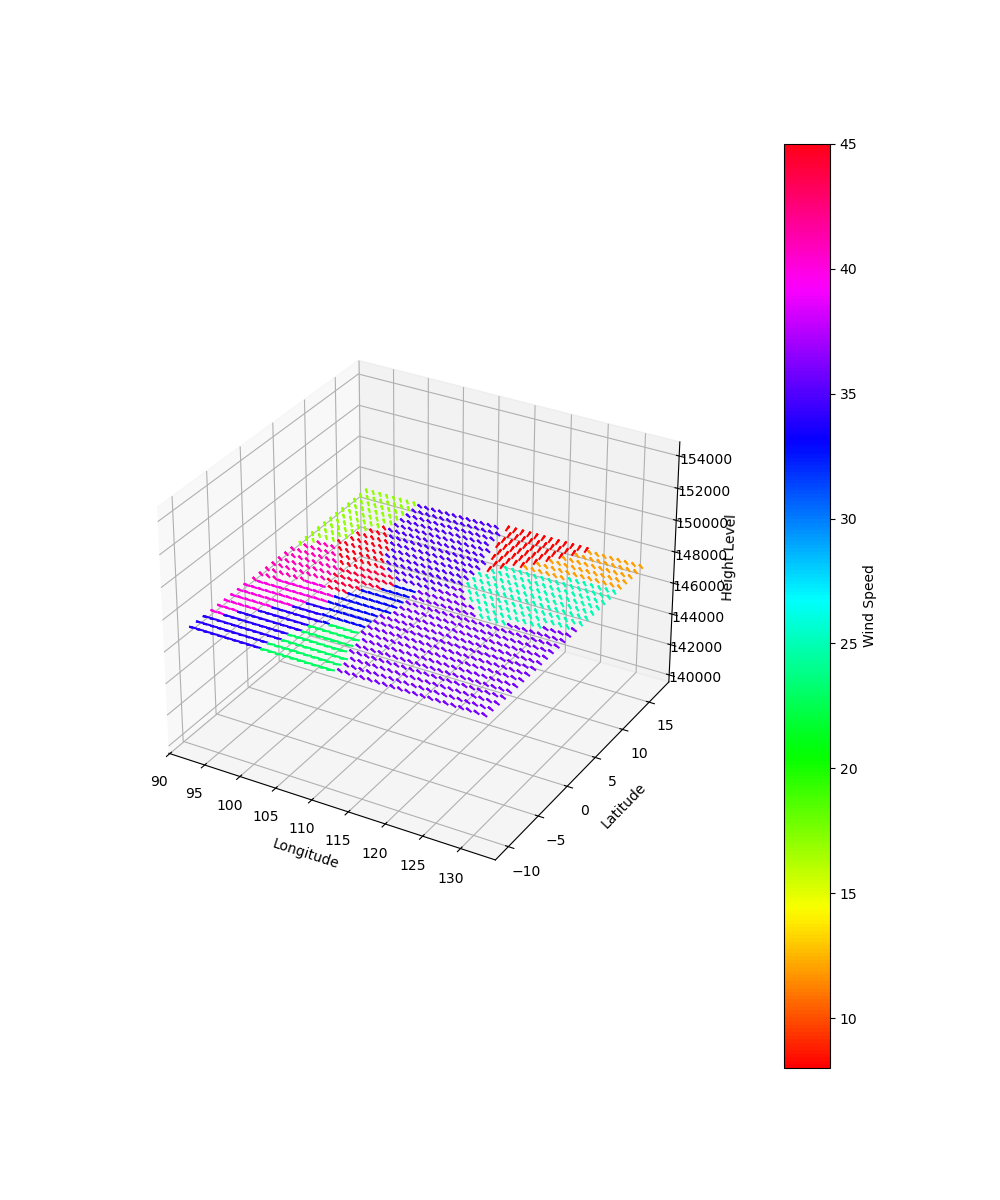

In [37]:
plot_layer(synth_df, 'xy', synth_df['height'][51])

In [416]:
alt = synth_df['height'].values#[::-1]
u_wind = synth_df['u_wind'].values
v_wind = synth_df['v_wind'].values
lat = synth_df['latitude'].values
lon = synth_df['longitude'].values
level = synth_df['pressure'].values#[::-1]
time = synth_df['timestep'].values

dims = [len(np.unique(lat)), len(np.unique(lon)), len(np.unique(level)), len(np.unique(time))]

lat_dim = len(np.unique(lat))
lon_dim = len(np.unique(lon))
level_dim = len(np.unique(level))
time_dim = len(np.unique(time))

print("dims", lat_dim, lon_dim, level_dim, time_dim)

alt_split = alt.reshape((time_dim, lat_dim, lon_dim, level_dim))
u_wind_split = u_wind.reshape((time_dim, lat_dim, lon_dim, level_dim))
v_wind_split = v_wind.reshape((time_dim, lat_dim, lon_dim, level_dim))

print(alt_split.shape)
print(np.transpose(alt_split, (0, 3, 1, 2)).shape)

ds = xr.Dataset(
    data_vars = {
        'z' : (['time','level','latitude','longitude'], np.transpose(alt_split,(0, 3, 1, 2))),
        'u' : (['time','level','latitude','longitude'], np.transpose(u_wind_split, (0, 3, 1, 2))),
        'v' : (['time','level','latitude','longitude'], np.transpose(v_wind_split, (0, 3, 1, 2))),
    },

    coords={
        'time' : np.unique(time),
        'level' : np.unique(level),
        'latitude' : np.unique(lat)[::-1],
        'longitude' : np.unique(lon),
        
    },

    attrs={
        'Conventions': 'CF-1.6'
    }
)

print(ds)

#Reverse Latitude to match ERA5
#ds.latitude = list(reversed(ds.latitude))

dims 28 40 52 1
(1, 28, 40, 52)
(1, 52, 28, 40)
<xarray.Dataset>
Dimensions:    (time: 1, level: 52, latitude: 28, longitude: 40)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01
  * level      (level) float64 16.77 17.42 18.09 18.79 ... 111.9 116.4 121.0
  * latitude   (latitude) float64 16.84 15.84 14.84 13.84 ... -8.16 -9.16 -10.16
  * longitude  (longitude) float64 92.71 93.71 94.71 95.71 ... 129.7 130.7 131.7
Data variables:
    z          (time, level, latitude, longitude) float64 2.723e+05 ... 1.472...
    u          (time, level, latitude, longitude) object 1.731 1.731 ... -35.31
    v          (time, level, latitude, longitude) object -6.46 -6.459 ... -1.063
Attributes:
    Conventions:  CF-1.6


In [406]:
ds.to_netcdf(r'/home/schuler/FLOW2D/forecasts/SynthCast4.nc', "w", format="NETCDF4")

In [407]:
ds

<xarray.Dataset>
Dimensions:    (time: 1, level: 52, latitude: 28, longitude: 40)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01
  * level      (level) float64 16.77 17.42 18.09 18.79 ... 111.9 116.4 121.0
  * latitude   (latitude) float64 16.84 15.84 14.84 13.84 ... -8.16 -9.16 -10.16
  * longitude  (longitude) float64 92.71 93.71 94.71 95.71 ... 129.7 130.7 131.7
Data variables:
    z          (time, level, latitude, longitude) float64 2.723e+05 ... 1.472...
    u          (time, level, latitude, longitude) object 1.731 1.731 ... -35.31
    v          (time, level, latitude, longitude) object -6.46 -6.459 ... -1.063
Attributes:
    Conventions:  CF-1.6